# Mean Shift Clustering Unsupervised

Mean shift builds upon the concept of kernel density estimation (KDE). Imagine that the data was sampled from a probability distribution. KDE is a method to estimate the underlying distribution (also called the probability density function) for a set of data.|

It works by placing a kernel on each point in the data set. A kernel is a fancy mathematical word for a weighting function. There are many different types of kernels, but the most popular one is the Gaussian kernel. Adding all of the individual kernels up generates a probability surface (e.g., density function). Depending on the kernel bandwidth parameter used, the resultant density function will vary.

Mean shift exploits this KDE idea by imagining what the points would do if they all climbed up hill to the nearest peak on the KDE surface. It does so by iteratively shifting each point uphill until it reaches a peak.

Depending on the kernel bandwidth used, the KDE surface (and end clustering) will be different. As an extreme case, imagine that we use extremely tall skinny kernels (e.g., a small kernel bandwidth). The resultant KDE surface will have a peak for each point. This will result in each point being placed into its own cluster. On the other hand, imagine that we use an extremely short fat kernels (e.g., a large kernel bandwidth). This will result in a wide smooth KDE surface with one peak that all of the points will climb up to, resulting in one cluster. Kernels in between these two extremes will result in nicer clusterings. Below are two animations of mean shift running for different kernel bandwidth values.

Iteratively playing around with the bandwith I was able to get two clusters when the bandwidth was 83. This bandwidth parameter will vary depending on the dataset. Therefore for prediction, entire datasets need to be run from the beginning and fitted with meanshift clustering.

This algorithm is parameter sensitive. it is one of the main drawbacks of using it

![Mean Shift2](datasets/ms_2d_bw_2.gif)

![Mean shift08](datasets/ms_2d_bw_.8.gif)

The top animation results in three KDE surface peaks, and thus three clusters. The second animation uses a smaller kernel bandwidth, and results in more than three clusters. As with all clustering problems, there is no correct clustering. Rather, correct is usually defined by what seems reasonable given the problem domain and application. Mean shift provides one nice knob (the kernel bandwidth parameter) that can easily be tuned appropriately for different applications.

In [1]:
from sklearn import datasets
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import cluster
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn import svm, neighbors
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import MeanShift, estimate_bandwidth

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score

import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import datetime

%matplotlib inline

In [2]:
train_split = 0.80
nrows = 250_000
path = 'c:/users/ugy1/abs/'
df=pd.read_csv(path+'datasets/processed_abs_loan_'+str(nrows)+'.csv', 
               #usecols=use_list, 
               #sep='\t',
               #compression=bz2,
               nrows=nrows,
               low_memory=False, 
              index_col=0, 
               parse_dates=True
              )
df.shape

(237024, 58)

In [3]:
column_list=df.columns.tolist()

In [4]:
df.head()

,originalloanamount,originalloanterm,originalinterestratepercentage,graceperiodnumber,obligorcreditscore,paymenttoincomepercentage,reportingperiodbeginningloanbalanceamount,nextreportingperiodpaymentamountdue,reportingperiodinterestratepercentage,nextinterestratepercentage,...,zerobalanceeffectivedate_calc,"zerobalance_[""99""]","zerobalance_[""1""]",S&P/Experian Auto Default Index,AutoIndex,BankCardIndex,FirstMortgageIndex,SecondMortgageIndex,CompositeIndex,label
0,66711.84,60,3.29,1,808.0,2.90,62677.27,0.0,3.3409,3.3409,...,0.0,1,0,0.0105,1.09,3.64,0.72,0.80,0.96,0
1,16258.45,60,0.90,0,821.0,4.36,12793.38,0.0,0.9049,0.9049,...,0.0,1,0,0.0105,1.09,3.64,0.72,0.80,0.96,0
2,31930.41,72,2.90,1,771.0,4.07,26981.85,0.0,2.9430,2.9430,...,0.0,1,0,0.0105,1.09,3.64,0.72,0.80,0.96,0
3,26065.02,65,0.90,0,890.0,5.00,4907.91,0.0,0.9037,0.9037,...,0.0,1,0,0.0093,0.99,3.86,0.68,0.59,0.92,0
4,42091.00,72,3.90,0,739.0,2.62,37060.44,0.0,3.9676,3.9676,...,0.0,1,0,0.0105,1.09,3.64,0.72,0.80,0.96,0


In [5]:
# prepare label for scikit-learn
Y=df.label.values
Y.shape

(237024,)

In [6]:
# prepare input data for scikit-learn
input=df.values
input.shape

(237024, 58)

In [7]:
# calculate train/test split

len_train = int(len(input)*train_split)
print(len_train)

189619


In [8]:
# apply train/test split to labels
y_train = Y[0:len_train]
y_test = Y[len_train:]
x_train = input[0:len_train]
x_test = input[len_train:]
x_train.shape

(189619, 58)

In [9]:
export_x_test = pd.DataFrame(data=x_test)

In [10]:
export_x_test.columns=column_list
export_x_test.rename(columns={'label':'True Label'}, inplace=True)
export_x_test.head()

,originalloanamount,originalloanterm,originalinterestratepercentage,graceperiodnumber,obligorcreditscore,paymenttoincomepercentage,reportingperiodbeginningloanbalanceamount,nextreportingperiodpaymentamountdue,reportingperiodinterestratepercentage,nextinterestratepercentage,...,zerobalanceeffectivedate_calc,"zerobalance_[""99""]","zerobalance_[""1""]",S&P/Experian Auto Default Index,AutoIndex,BankCardIndex,FirstMortgageIndex,SecondMortgageIndex,CompositeIndex,True Label
0,36863.24,72.0,1.00,1.0,871.0,2.59,20842.67,0.0,1.0042,1.0042,...,0.0,1.0,0.0,0.0110,1.11,3.28,0.66,1.08,0.89,0.0
1,23811.32,60.0,1.90,0.0,845.0,4.12,7241.37,0.0,1.9163,1.9163,...,0.0,1.0,0.0,0.0099,0.99,3.86,0.68,0.59,0.92,0.0
2,30669.00,48.0,1.00,1.0,863.0,10.67,21859.06,0.0,1.0055,1.0055,...,0.0,1.0,0.0,0.0105,1.09,3.64,0.72,0.80,0.96,0.0
3,54083.21,72.0,1.00,0.0,682.0,4.42,50431.21,0.0,1.0045,1.0045,...,0.0,1.0,0.0,0.0105,1.09,3.64,0.72,0.80,0.96,0.0
4,31557.75,72.0,3.89,1.0,761.0,2.56,22262.79,0.0,3.9584,3.9584,...,0.0,1.0,0.0,0.0110,1.11,3.28,0.66,1.08,0.89,0.0


In [11]:
#from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import minmax_scale
# from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import RobustScaler
# from sklearn.preprocessing import Normalizer
# from sklearn.preprocessing import QuantileTransformer
# from sklearn.preprocessing import PowerTransformer

In [12]:
x_scaler=StandardScaler()
x_train = x_scaler.fit_transform(x_train)
x_test = x_scaler.fit_transform(x_test)

In [13]:
#bandwidth = estimate_bandwidth(x_test, quantile=0.2, n_samples=1000)
bandwidth=83
ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
clf_ms= ms.fit(x_test)    

In [14]:
x_pred = x_test

In [15]:
prediction_ms = clf_ms.predict(x_pred)

In [16]:
prediction_ms = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(prediction_ms)
n_clusters_ = len(np.unique(prediction_ms))

In [17]:
print('Number of clusters :', n_clusters_)

Number of clusters : 2


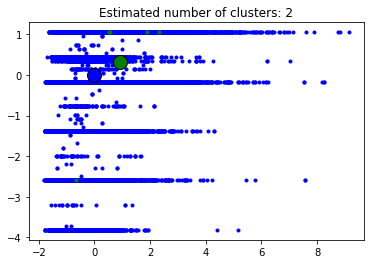

In [18]:
# Plot result
import matplotlib.pyplot as plt
from itertools import cycle

plt.figure(1)
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    my_members = prediction_ms == k
    cluster_center = cluster_centers[k]
    plt.plot(x_test[my_members, 0], x_test[my_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [19]:
np.unique(prediction_ms)

array([0, 1], dtype=int64)

In [20]:
np.bincount(np.array(prediction_ms).reshape(1,prediction_ms.size)[0])

array([47400,     5], dtype=int64)

In [21]:
export_x_test['Predicted Label']=prediction_ms

In [22]:
export_x_test.head()

,originalloanamount,originalloanterm,originalinterestratepercentage,graceperiodnumber,obligorcreditscore,paymenttoincomepercentage,reportingperiodbeginningloanbalanceamount,nextreportingperiodpaymentamountdue,reportingperiodinterestratepercentage,nextinterestratepercentage,...,"zerobalance_[""99""]","zerobalance_[""1""]",S&P/Experian Auto Default Index,AutoIndex,BankCardIndex,FirstMortgageIndex,SecondMortgageIndex,CompositeIndex,True Label,Predicted Label
0,36863.24,72.0,1.00,1.0,871.0,2.59,20842.67,0.0,1.0042,1.0042,...,1.0,0.0,0.0110,1.11,3.28,0.66,1.08,0.89,0.0,0
1,23811.32,60.0,1.90,0.0,845.0,4.12,7241.37,0.0,1.9163,1.9163,...,1.0,0.0,0.0099,0.99,3.86,0.68,0.59,0.92,0.0,0
2,30669.00,48.0,1.00,1.0,863.0,10.67,21859.06,0.0,1.0055,1.0055,...,1.0,0.0,0.0105,1.09,3.64,0.72,0.80,0.96,0.0,0
3,54083.21,72.0,1.00,0.0,682.0,4.42,50431.21,0.0,1.0045,1.0045,...,1.0,0.0,0.0105,1.09,3.64,0.72,0.80,0.96,0.0,0
4,31557.75,72.0,3.89,1.0,761.0,2.56,22262.79,0.0,3.9584,3.9584,...,1.0,0.0,0.0110,1.11,3.28,0.66,1.08,0.89,0.0,0


In [23]:
export_x_test.shape

(47405, 59)

In [24]:
export_x_test.to_csv(path+"prediction/ms/predicated_ms_abs_loans_"+str(nrows)+".csv", chunksize=10000)

In [28]:
def plot_confusion_matrix(cm, title, classes=['Current', 'Non_Current'],
                          cmap=plt.cm.Blues, save=False, saveas="MyFigure.png"):
    
    # print Confusion matrix with blue gradient colours
    
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.1%'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    if save:
        plt.savefig(saveas, dpi=100)

In [29]:
def plot_gridsearch_cv(results, estimator, x_min, x_max, y_min, y_max,save=False, saveas="MyFigure.png"):
    
    # print GridSearch cross-validation for parameters
    
    plt.figure(figsize=(10,8))
    plt.title("GridSearchCV for "+estimator, fontsize=24)

    plt.xlabel(estimator)
    plt.ylabel("Score")
    plt.grid()

    ax = plt.axes()
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

    pad = 0.005
    X_axis = np.array(results["param_"+estimator].data, dtype=float)

    for scorer, color in zip(sorted(scoring), ['b', 'k']):
        for sample, style in (('train', '--'), ('test', '-')):
            sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
            sample_score_std = results['std_%s_%s' % (sample, scorer)]
            ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 if sample == 'test' else 0, color=color)
            ax.plot(X_axis, sample_score_mean, style, color=color,
                alpha=1 if sample == 'test' else 0.7,
                label="%s (%s)" % (scorer, sample))

        best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
        best_score = results['mean_test_%s' % scorer][best_index]

        # Plot a dotted vertical line at the best score for that scorer marked by x
        ax.plot([X_axis[best_index], ] * 2, [0, best_score],
            linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

        # Annotate the best score for that scorer
        ax.annotate("%0.2f" % best_score,
                (X_axis[best_index], best_score+pad))

    plt.legend(loc="best")
    plt.grid('off')
    plt.tight_layout()
    if save:
        plt.savefig(saveas, dpi=100)
        
    plt.show()

             precision    recall  f1-score   support

    Current       0.97      1.00      0.98     45938
Non_Current       0.20      0.00      0.00      1467

avg / total       0.95      0.97      0.95     47405

AUC:  50.0%


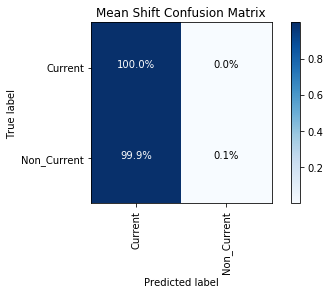

In [31]:
print(classification_report(y_test, prediction_ms, target_names=['Current', 'Non_Current']))
print ("AUC: ", "{:.1%}".format(roc_auc_score(y_test, prediction_ms)))
cm = confusion_matrix(y_test, prediction_ms)
plot_confusion_matrix(cm, title="Mean Shift Confusion Matrix",save=True, 
                      saveas='prediction/ms/cm'+str(' Mean shift Accuracy-')+str(nrows)+'.jpg')


ROC_AUC_SCORE ;  0.500297294688
Confusion matrix, without normalization
[[45934     4]
 [ 1466     1]]


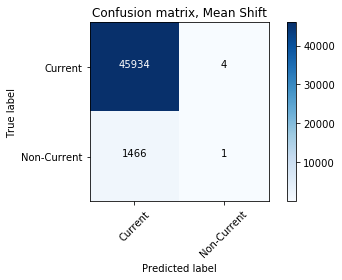

In [32]:
class_names = ['Current', 'Non-Current']

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


print('ROC_AUC_SCORE ; ', roc_auc_score(y_test, prediction_ms))
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, prediction_ms)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title= 'Confusion matrix, Mean Shift')
plt.savefig('prediction/ms/cm'+str(' ms-')+str(nrows)+'.jpg')
plt.show()